Import libraries

In [128]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch, re
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(42)
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix, top_k_accuracy_score
)
import matplotlib
#matplotlib.use('TkAgg')  # or 'MacOSX' if on macOS
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


Read data

In [129]:
###VALDIATION AND TRAINING DATA
TRAINING_FOLDER = "/Users/robinoscarsson/PycharmProjects/tra300-ski-technique-classification/data_sync/outputs/Training_and_validation_set"

csv_files = [f for f in os.listdir(TRAINING_FOLDER) if f.endswith('.csv')]

dataframes = {}
for file in csv_files:
    full_path = os.path.join(TRAINING_FOLDER, file)
    df = pd.read_csv(full_path)
    dataframes[file] = df


In [130]:
###TEST DATA
TEST_FOLDER = "/Users/robinoscarsson/PycharmProjects/tra300-ski-technique-classification/data_sync/outputs/Test_set"

csv_files = [f for f in os.listdir(TEST_FOLDER) if f.endswith('.csv')]
dataframes_test = {}
for file in csv_files:
    full_path = os.path.join(TEST_FOLDER, file)
    df = pd.read_csv(full_path)
    dataframes_test[file] = df

In [131]:
####
input_cols = ["speed_kmph", "power_w", "frequency_ppm", "thrust_left_ms", "thrust_right_ms", "impulse_left_ns", "impulse_right_ns", "force_meanl_n", "force_meanr_n", "f_tot_mean_n"] #ADD columns from avaialble ones if needed
output_cols = ["Gear"]

print("Loaded CSV files:")
for k in sorted(dataframes.keys()):
    print(" •", k)

# Take a sample frame to list columns
_sample_key = next(iter(dataframes))
print("\nColumns in sample file:", _sample_key)
print(list(dataframes[_sample_key].columns))

print("\nUsing inputs:", input_cols)
print("Using output:", output_cols)


Loaded CSV files:
 • BIA24-15_NR_merged_with_gear.csv
 • BIA24-15_WR_merged_with_gear.csv
 • BIA24-16_NR_merged_with_gear.csv
 • BIA24-16_WR_merged_with_gear.csv
 • BIA24-17_WR_merged_with_gear.csv
 • BIA24-18_NR_merged_with_gear.csv
 • BIA24-18_WR_merged_with_gear.csv
 • BIA24-19_NR_merged_with_gear.csv
 • BIA24-19_WR_merged_with_gear.csv
 • BIA24-20_NR_merged_with_gear.csv
 • BIA24-20_WR_merged_with_gear.csv
 • BIA24-3_NR_merged_with_gear.csv
 • BIA24-3_WR_merged_with_gear.csv
 • BIA24-4_NR_merged_with_gear.csv
 • BIA24-4_WR_merged_with_gear.csv
 • BIA24-5_NR_merged_with_gear.csv
 • BIA24-5_WR_merged_with_gear.csv
 • BIA24-7_NR_merged_with_gear.csv
 • BIA24-7_WR_merged_with_gear.csv
 • BIA24-9_NR_merged_with_gear.csv
 • BIA24-9_WR_merged_with_gear.csv

Columns in sample file: BIA24-17_WR_merged_with_gear.csv
['tt_s', 'Lap', 'Gear', 'ns1:LatitudeDegrees', 'ns1:LongitudeDegrees', 'Sport', 'speed_kmph', 'power_w', 'frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 

In [132]:
#Split into train/test dataframes and make sure there are no NA
train_keys = [k for k in dataframes.keys()]
test_keys = [k for k in dataframes_test.keys()]

train_df_full = pd.concat([dataframes[k] for k in train_keys], ignore_index=True) # Renamed
test_df = pd.concat([dataframes_test[k] for k in test_keys], ignore_index=True) # Renamed

needed_cols = list(set(input_cols + output_cols))
train_df_full = train_df_full.dropna(subset=needed_cols).reset_index(drop=True)
test_df = test_df.dropna(subset=needed_cols).reset_index(drop=True)


In [133]:
# Normalize labels: "2.0H" / "2.0V" / "2.0" -> "2.0"
label_col = output_cols[0]

def normalize_label(val: object) -> str:
    s = str(val).strip()
    m = re.search(r'^-?\d+(?:\.\d+)?', s) # take leading number (int or float)
    if m:
        return f"{float(m.group(0)):.1f}" # standardize format, e.g., 2 -> "2.0"
    return s # fall back to original string

train_df_full[label_col] = train_df_full[label_col].apply(normalize_label)
test_df[label_col] = test_df[label_col].apply(normalize_label)

In [134]:
# Create Train/Validation SpliT
# We split the full training data into a new (smaller) training set
# and a validation set.

try:
    train_df, val_df = train_test_split(
        train_df_full,
        test_size=0.2, # 20% for validation
        random_state=42,
        stratify=train_df_full[label_col] # Keep class distribution in splits
    )
except ValueError:
    print("Warning: Could not stratify split (likely due to rare classes). Splitting without stratification.")
    train_df, val_df = train_test_split(
        train_df_full,
        test_size=0.2, # 20% for validation
        random_state=42
    )


In [135]:
###Encode labels and make sure they are represented everywhere

# Encode labels using ALL labels (train_full + test) to avoid unseen-label errors
label_encoder = LabelEncoder()

#Concentenate to get one long list of labels in the
all_labels = pd.concat(
    [train_df_full[label_col], test_df[label_col]], # Use train_df_full here
    ignore_index=True
)
#Makes all lables which are strings into integers (in this case it is just e.g "1.0" -> 1
label_encoder.fit(all_labels)

###NOW TURN COLUMNS IN DATAFRAMES OF LABELS INTO THIS MAPPING (I.E into integers
y_train = label_encoder.transform(train_df[label_col]) # Use new train_df
y_val = label_encoder.transform(val_df[label_col])     # Create y_val
y_test = label_encoder.transform(test_df[label_col])
num_classes = len(label_encoder.classes_)


###Sanity check to make sure or chosen test files don't contain gears that don't exist in other sets
#create python sets of classes found in all data sets
train_classes = set(np.unique(y_train))
val_classes = set(np.unique(y_val))
test_classes = set(np.unique(y_test))

#If any class is only in test creating warning
only_in_test = sorted(list(test_classes - train_classes - val_classes))
if only_in_test:
    names_only_in_test = [label_encoder.classes_[i] for i in only_in_test]
    print("⚠️ These classes exist only in TEST (not seen in train/val):", names_only_in_test)


In [136]:
# Prepare inputs in terms of each timestep
X_train = train_df[input_cols].values.astype(np.float32)
X_val = val_df[input_cols].values.astype(np.float32)     # Create X_val
X_test = test_df[input_cols].values.astype(np.float32)

# ---- Convert to PyTorch tensors ----
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)   # Create X_val_t
X_test_t = torch.tensor(X_test, dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t = torch.tensor(y_val, dtype=torch.long)     # Create y_val_t
y_test_t = torch.tensor(y_test, dtype=torch.long)

print(X_train_t.shape)

torch.Size([19611, 10])


In [137]:
###MAKE TENSOR DATA INTO SEQUENCES FOR RNN (IGNORE FOR NON SEQUENTIAL ARCHITECTURES)

SEQ_LEN = 10    # length of each sequence in seconds (samples)
STRIDE = 2      # how much to slide the window forward

def make_sequences(X_t, y_t, seq_len=SEQ_LEN, stride=STRIDE):
    """
    #Turn flat sensor data (N x features) into overlapping sequences for RNNs.
    """
    X_seq, y_seq = [], []
    for i in range(0, len(X_t) - seq_len + 1, stride):
        X_seq.append(X_t[i:i+seq_len])
        y_seq.append(y_t[i+seq_len-1])
    X_seq = torch.stack(X_seq)      # shape: (num_sequences, seq_len, num_features)
    y_seq = torch.stack(y_seq)      # shape: (num_sequences,)
    return X_seq, y_seq

# Apply to train, val, and test
X_train_seq, y_train_seq = make_sequences(X_train_t, y_train_t)
X_val_seq, y_val_seq     = make_sequences(X_val_t, y_val_t)
X_test_seq, y_test_seq   = make_sequences(X_test_t, y_test_t)

print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"X_val_seq shape:   {X_val_seq.shape}")
print(f"X_test_seq shape:  {X_test_seq.shape}")


X_train_seq shape: torch.Size([9801, 10, 10])
X_val_seq shape:   torch.Size([2447, 10, 10])
X_test_seq shape:  torch.Size([2337, 10, 10])


In [138]:
#### WEIGHT Class weights (based on new, smaller training set)

input_dim = X_train_t.shape[1]
output_dim = num_classes

counts_np = np.bincount(y_train_seq, minlength=num_classes)
class_counts = torch.tensor(counts_np, dtype=torch.float32)
with torch.no_grad():
    class_weights = torch.where(class_counts > 0, 1.0 / class_counts, torch.tensor(0.0))
    nz = class_weights > 0
    if nz.any():
        class_weights[nz] = class_weights[nz] * (nz.sum() / class_weights[nz].sum())

print(f"The amount of inputs: Train size: {len(X_train_seq)} | Val size: {len(X_val_seq)} | Test size: {len(X_test_seq)}")
print(f"Input dim: {input_dim} | Classes: {num_classes}")
print("Label mapping (int -> original):")
for i, name in enumerate(label_encoder.classes_):
    print(f"  {i} -> {name}")
print("Training Class counts (amount of gears):", counts_np.tolist())
print(f"the weights are {class_weights}")

The amount of inputs: Train size: 9801 | Val size: 2447 | Test size: 2337
Input dim: 10 | Classes: 4
Label mapping (int -> original):
  0 -> 0.0
  1 -> 2.0
  2 -> 3.0
  3 -> 4.0
Training Class counts (amount of gears): [1840, 1419, 5162, 1380]
the weights are tensor([1.0034, 1.3011, 0.3577, 1.3379])


In [152]:
###HELPER FUNCTIONS

def plot_training(epochs, train_losses, val_losses):
    """Plot the training and validation losses."""
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, "--", label="Validation Loss")
    plt.xlabel("Epoch"), plt.xlim([0, epochs - 1])
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def batches(X, y, batch_size, shuffle=True):
    n = len(X)
    idx = np.arange(n)

    #We don't want to shuffle for validation and training
    if shuffle:
        np.random.shuffle(idx)
    for start in range(0, n, batch_size):
        end = start + batch_size
        sel = idx[start:end]
        yield X[sel], y[sel]

# Source - https://stackoverflow.com/a
# Posted by isle_of_gods, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-12, License - CC BY-SA 4.0
class EarlyStopper:
    def __init__(self, patience=5, min_delta= 1e-3):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


RNN architecture

In [172]:
####ARCHITECTURE
EPOCHS = 100
BATCH_SIZE = 128
PRINT_EVERY = 1
hidden_size = 16

model = nn.RNN(input_size=input_dim, hidden_size= hidden_size, num_layers=3, nonlinearity='relu', batch_first=True)
fc = nn.Linear(hidden_size, output_dim)  # Map hidden state → class logits
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

Starting training...
Epoch 001 | Train loss: 1.3129 | Val loss: 1.1873 | Val Acc: 0.3363
Epoch 002 | Train loss: 1.0451 | Val loss: 0.9826 | Val Acc: 0.5501
Epoch 003 | Train loss: 0.9658 | Val loss: 0.9470 | Val Acc: 0.6060
Epoch 004 | Train loss: 0.9375 | Val loss: 0.9311 | Val Acc: 0.5623
Epoch 005 | Train loss: 0.9241 | Val loss: 0.9157 | Val Acc: 0.6126
Epoch 006 | Train loss: 0.9121 | Val loss: 0.9099 | Val Acc: 0.6040
Epoch 007 | Train loss: 0.9042 | Val loss: 0.9025 | Val Acc: 0.6257
Epoch 008 | Train loss: 0.9016 | Val loss: 0.8989 | Val Acc: 0.6457
Epoch 009 | Train loss: 0.8986 | Val loss: 0.9074 | Val Acc: 0.5889
Epoch 010 | Train loss: 0.8927 | Val loss: 0.8872 | Val Acc: 0.6261
Epoch 011 | Train loss: 0.8908 | Val loss: 0.8909 | Val Acc: 0.6306
Epoch 012 | Train loss: 0.8856 | Val loss: 0.8828 | Val Acc: 0.6404
Epoch 013 | Train loss: 0.8831 | Val loss: 0.8869 | Val Acc: 0.6007
Epoch 014 | Train loss: 0.8804 | Val loss: 0.8817 | Val Acc: 0.6302
Epoch 015 | Train loss: 0.8

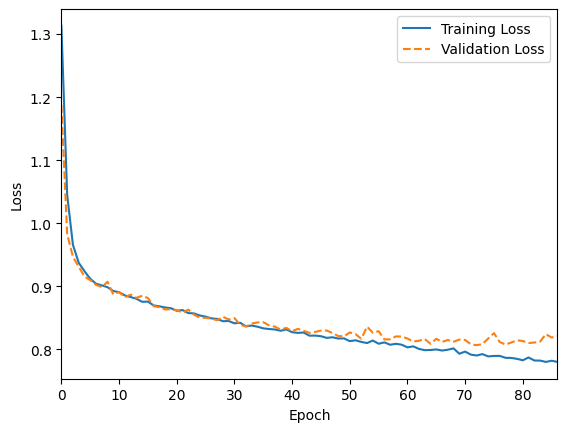

Training finished.

Using model state from final epoch for evaluation.


In [173]:
### Training loop
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print("Starting training...")
early_stopper = EarlyStopper(patience=5, min_delta=0.01)
#in case early stopping
epoch_counter = 1

for epoch in range(1, EPOCHS + 1):
    # --- Training Phase ---
    model.train()
    fc.train()
    running_loss = 0.0
    for Xb, yb in batches(X_train_seq, y_train_seq, BATCH_SIZE):
        optimizer.zero_grad()

        out, h_n = model(Xb)
        out = out[:, -1,:]
        out = fc(out)

        loss = criterion(out, yb)
        loss.backward()

        optimizer.step()
        running_loss += loss.item() * Xb.size(0)

    avg_train_loss = running_loss / len(X_train_seq)
    history['train_loss'].append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    fc.eval()

    val_loss = 0.0
    val_correct = 0
    total_samples = 0

    with torch.no_grad():
        for Xb, yb in batches(X_val_seq, y_val_seq, BATCH_SIZE, shuffle=False):
            out, _ = model(Xb)
            out = out[:, -1, :]
            out = fc(out)

            loss = criterion(out, yb)
            val_loss += loss.item() * Xb.size(0)   # weight by batch size

            preds = out.argmax(dim=1)
            val_correct += (preds == yb).sum().item()
            total_samples += Xb.size(0)
    avg_val_loss = val_loss / total_samples
    val_accuracy = val_correct / total_samples
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    # --- Print Epoch Stats ---
    if epoch % PRINT_EVERY == 0:
        print(f"Epoch {epoch:03d} | Train loss: {avg_train_loss:.4f} | Val loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    if early_stopper.early_stop(avg_val_loss):
        print("Early stopping")
        break

    epoch_counter += 1

if epoch_counter<EPOCHS:
    plot_training(epoch_counter, history['train_loss'], history['val_loss'])
else:
    plot_training(EPOCHS, history['train_loss'], history['val_loss'])

    # --- (Removed "Save Best Model" block) ---

print("Training finished.")

# --- (Removed "Load Best Model" block) ---
print("\nUsing model state from final epoch for evaluation.")

Test Accuracy: 0.6585


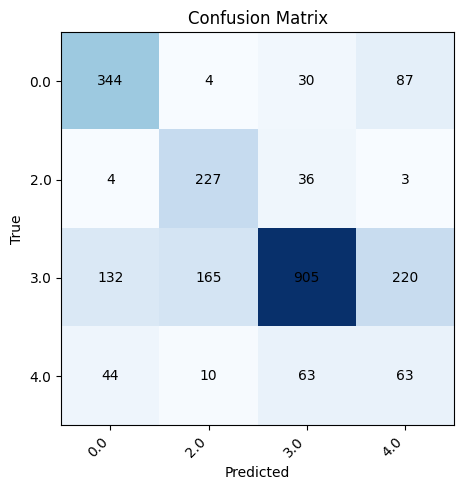

In [174]:
model.eval()
fc.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for Xb, yb in batches(X_test_seq, y_test_seq, BATCH_SIZE, shuffle=False):
        out, _ = model(Xb)          # (batch, seq_len, hidden)
        out = out[:, -1, :]       # take last timestep
        logits = fc(out)          # (batch, num_classes)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu())
        all_true.append(yb.cpu())
# Concatenate all batches
y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_true).numpy()

# Compute accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# Confusion matrix
target_names = list(label_encoder.classes_)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(target_names)), labels=target_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(target_names)), labels=target_names)

# Annotate each cell
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center', color='black')

plt.tight_layout()
plt.show()